In [15]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [150]:
df = pd.read_csv("data/iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [151]:

y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy()
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-setosa") - int(x != "Iris-setosa"))
y = y[['variety']].to_numpy()

In [131]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1, lambda_=0): #Добавил параметр лямбда для регуляризации

        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.lambda_ = lambda_ #коэффициент регуляризации
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0
        
        
    def start_timer(self):
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self):
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self):
        return self.timer.sum()

    def get_times(self):
        return self.timer
    
    def step_package(self):
        self.start_timer()
        self.w = self.w - self.h * self.grad()

    
    def step_mini_batch(self):
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self):
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()

            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2)

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1)
    
    

In [132]:

class SupportVectorMachine(GradientDescent):#наследуемся от градиентного спуска
    
    def grad(self, X = None, y = None): #переопределяем вычисление градиента для нового класса svm
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y
        grad = np.zeros(self.width)
        for i in range(len(y)):
            if 1 - y[i]*np.dot(self.w, X[i, :]) > 0:
                grad += -y[i] * X[i, :]
                
        return 2*self.lambda_*self.w + grad #пока написал корявый градиент пускай хотя бы так считает
    
    
    def calc_q(self): #переопределяем функцию ошибки
        loss_result = self.lambda_*((self.w**2).sum())
        for i in range(len(y)):
            loss_result += max(0, 1 - y[i]*np.dot(self.w, self.X[i, :]))
        return loss_result[0]
    
    def predict(self, X): #переопределяем функцию предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.sign(np.dot(X, self.w).reshape(-1, 1))



In [133]:

svm = SupportVectorMachine(X,y, logging=True, min_iterations=1000) #специально переобучились)
svm.fit()

Величина ошибки на каждом шаге
Шаг 1: ошибка 1089.2;
Шаг 2: ошибка 1064.9;
Шаг 3: ошибка 1040.7;
Шаг 4: ошибка 1016.5;
Шаг 5: ошибка 992.2;
Шаг 6: ошибка 968.0;
Шаг 7: ошибка 943.8;
Шаг 8: ошибка 919.6;
Шаг 9: ошибка 895.3;
Шаг 10: ошибка 871.1;
Шаг 11: ошибка 846.9;
Шаг 12: ошибка 822.6;
Шаг 13: ошибка 798.4;
Шаг 14: ошибка 774.2;
Шаг 15: ошибка 749.9;
Шаг 16: ошибка 725.7;
Шаг 17: ошибка 701.5;
Шаг 18: ошибка 677.3;
Шаг 19: ошибка 653.0;
Шаг 20: ошибка 628.8;
Шаг 21: ошибка 604.6;
Шаг 22: ошибка 580.3;
Шаг 23: ошибка 556.1;
Шаг 24: ошибка 531.9;
Шаг 25: ошибка 507.6;
Шаг 26: ошибка 483.4;
Шаг 27: ошибка 459.2;
Шаг 28: ошибка 434.9;
Шаг 29: ошибка 410.7;
Шаг 30: ошибка 386.5;
Шаг 31: ошибка 362.3;
Шаг 32: ошибка 338.0;
Шаг 33: ошибка 313.8;
Шаг 34: ошибка 289.6;
Шаг 35: ошибка 265.3;
Шаг 36: ошибка 241.1;
Шаг 37: ошибка 216.9;
Шаг 38: ошибка 192.6;
Шаг 39: ошибка 168.6;
Шаг 40: ошибка 146.7;
Шаг 41: ошибка 134.3;
Шаг 42: ошибка 125.7;
Шаг 43: ошибка 117.9;
Шаг 44: ошибка 110.0;
Шаг 45

array([ 0.916   , -1.155915,  1.70976 ])

In [149]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def plot_confusion_matrix(y_pred_clf):
    y_pred_clf = svm.predict(X)
    
    cm = confusion_matrix(y, y_pred_clf)
    print('Матрица ошибок, полученная методом confusion_matrix\n', cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Матрица ошибок')
    plt.show()
    
def calc_metrics(y_pred_clf):
    acc = accuracy_score(y, y_pred_clf)
    pre = precision_score(y, y_pred_clf)
    rec = recall_score(y, y_pred_clf)
    f1 = f1_score(y, y_pred_clf)
    print(f"accuracy: {acc}")
    print(f"precision: {pre}")
    print(f"recall: {rec}")
    print(f"f1: {f1}")

In [153]:
y_pred = svm.predict(X)

In [154]:
calc_metrics(y_pred)

accuracy: 0.9933333333333333
precision: 1.0
recall: 0.98
f1: 0.98989898989899


Матрица ошибок, полученная методом confusion_matrix
 [[100   0]
 [  1  49]]


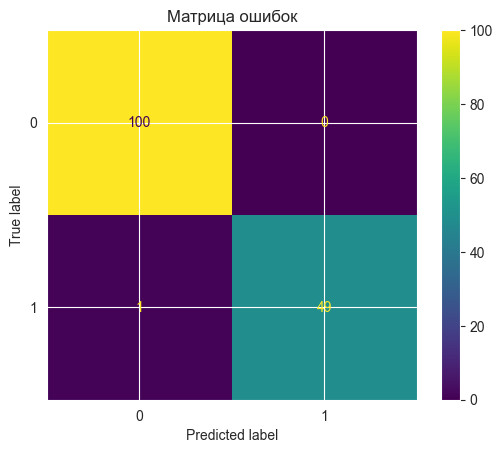

In [155]:
plot_confusion_matrix(y_pred)

In [156]:
svmmb = SupportVectorMachine(X, y, logging=True, h=0.0005, min_iterations=1000, strategy='mini-batch') #специально переобучились)

In [157]:
svmmb.fit()

Величина ошибки на каждом шаге
Шаг 1: ошибка 1113.4;
Шаг 2: ошибка 1111.0;
Шаг 3: ошибка 1108.5;
Шаг 4: ошибка 1106.6;
Шаг 5: ошибка 1104.2;
Шаг 6: ошибка 1102.1;
Шаг 7: ошибка 1099.8;
Шаг 8: ошибка 1097.3;
Шаг 9: ошибка 1094.7;
Шаг 10: ошибка 1094.7;
Шаг 11: ошибка 1094.7;
Шаг 12: ошибка 1092.6;
Шаг 13: ошибка 1090.2;
Шаг 14: ошибка 1087.8;
Шаг 15: ошибка 1085.6;
Шаг 16: ошибка 1082.5;
Шаг 17: ошибка 1080.0;
Шаг 18: ошибка 1077.8;
Шаг 19: ошибка 1077.8;
Шаг 20: ошибка 1077.8;
Шаг 21: ошибка 1075.6;
Шаг 22: ошибка 1073.4;
Шаг 23: ошибка 1073.4;
Шаг 24: ошибка 1071.0;
Шаг 25: ошибка 1069.0;
Шаг 26: ошибка 1069.0;
Шаг 27: ошибка 1069.0;
Шаг 28: ошибка 1066.8;
Шаг 29: ошибка 1064.4;
Шаг 30: ошибка 1062.1;
Шаг 31: ошибка 1059.0;
Шаг 32: ошибка 1056.1;
Шаг 33: ошибка 1056.1;
Шаг 34: ошибка 1053.6;
Шаг 35: ошибка 1053.6;
Шаг 36: ошибка 1050.6;
Шаг 37: ошибка 1048.0;
Шаг 38: ошибка 1045.3;
Шаг 39: ошибка 1045.3;
Шаг 40: ошибка 1045.3;
Шаг 41: ошибка 1043.4;
Шаг 42: ошибка 1041.0;
Шаг 43: ошиб

array([ 0.777 , -0.4611,  0.3921])

In [158]:
y_pred = svmmb.predict(X)

Матрица ошибок, полученная методом confusion_matrix
 [[100   0]
 [  1  49]]


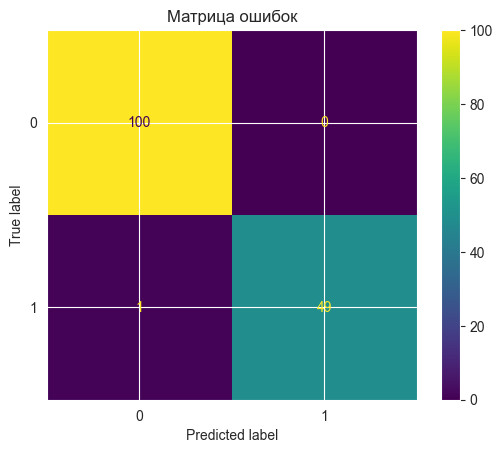

In [159]:
plot_confusion_matrix(y_pred)

In [160]:
calc_metrics(y_pred)

accuracy: 0.68
precision: 1.0
recall: 0.04
f1: 0.07692307692307693
